In [267]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import datetime

now = datetime.datetime.now().strftime("%Y-%m-%d")

In [436]:
scaling = False
TICKER = '^GSPC' #USDCHF=X
INTERVAL = '1d'
START_TRAIN = '2015-11-01'
END_TRAIN = '2024-11-01'
START_TEST = '2024-11-01'
END_TEST = now
NR_OF_STATES = 2

In [437]:
# Get train data
ticker_yahoo = yf.Ticker(TICKER)
data = ticker_yahoo.history(period=PERIOD, interval=INTERVAL, start=START_TRAIN, end=END_TRAIN)
last_quote = data['Close'].iloc[-1]
data['Returns'] = data['Close'].pct_change().fillna(0)
data['LogReturns'] = np.log1p(data['Returns'])
data['Volatility'] = data['LogReturns'].rolling(window=20).std().fillna(0)
data = data.reset_index()
if 'Datetime' in data.columns:
    data.rename(columns={'Datetime': 'Date'}, inplace=True)
print(ticker, last_quote)

USDJPY=X 5705.4501953125


In [438]:
data.shape

(2265, 11)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


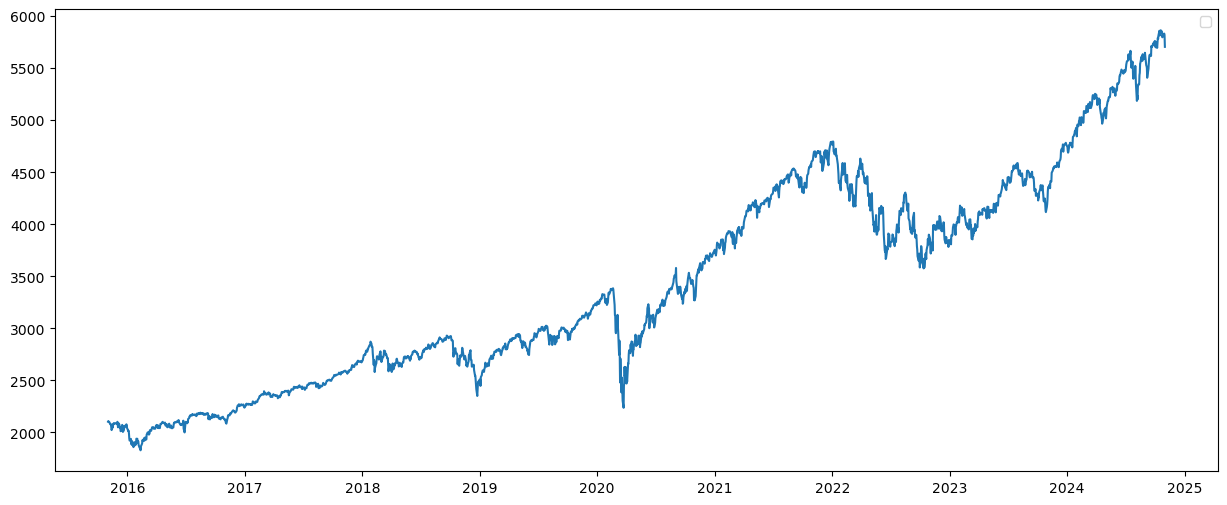

In [439]:
# Plot train data
plt.figure(figsize=(15, 6))
plt.plot(data['Date'], data['Close'])
plt.legend()
plt.show()

In [440]:
# Preparing model input
observables = data[['LogReturns', 'Volatility']].values #
if scaling:
    scaler = StandardScaler()
    observables = scaler.fit_transform(observables)

In [441]:
# Fitting the model

hmm = GaussianHMM(n_components=NR_OF_STATES, covariance_type='full', n_iter=10000, random_state=42) #‘spherical’, ‘tied’, ‘diag’, ‘full’
hmm.fit(observables)

C:\Users\pawpi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


GaussianHMM(covariance_type='full', n_components=2, n_iter=10000,
            random_state=42)

In [442]:
# Back testing
hidden_states = hmm.predict(observables)
data['HiddenState'] = hidden_states

In [443]:
# Assigning states to strategy
print(data.groupby('HiddenState').agg({'Returns': 'mean'}))
print(data.groupby('HiddenState').agg({'Returns': 'count'}))
groups = data.groupby('HiddenState').agg({'Returns': 'mean'})
index_min = np.argmin(groups)
index_max = np.argmax(groups)
data['Signal'] = 0
data.loc[data['HiddenState'] == index_max, 'Signal'] = 1  # Buy
data.loc[data['HiddenState'] == index_min, 'Signal'] = -1 # Sell

              Returns
HiddenState          
0            0.000852
1           -0.000469
             Returns
HiddenState         
0               1671
1                594


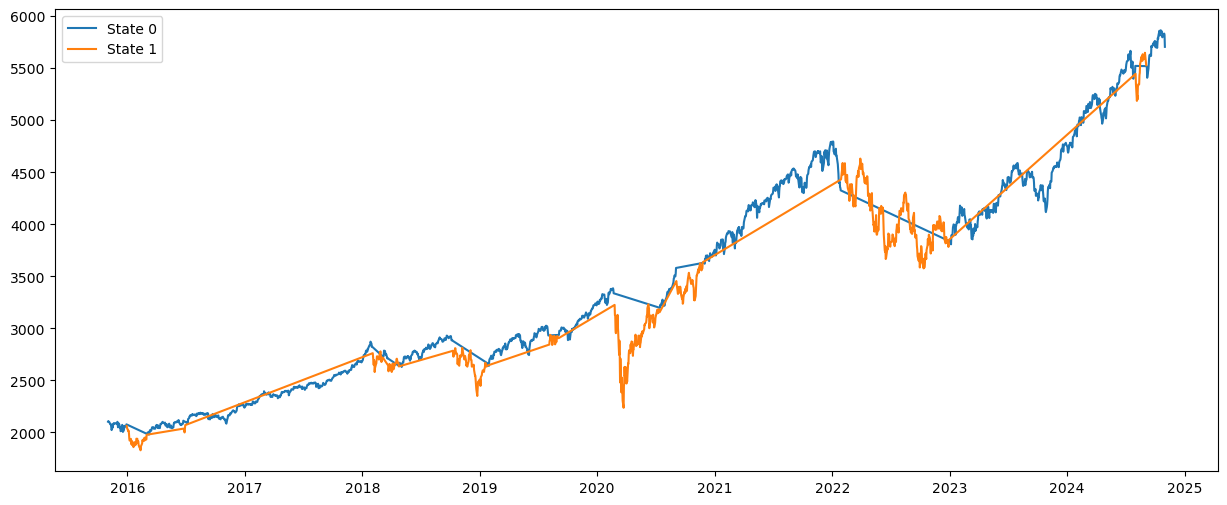

In [444]:
# Visualize the hidden states
plt.figure(figsize=(15, 6))
for state in range(hmm.n_components):
    state_data = data[data['HiddenState'] == state]
    plt.plot(state_data['Date'], state_data['Close'], label=f"State {state}")
plt.legend()
plt.show()

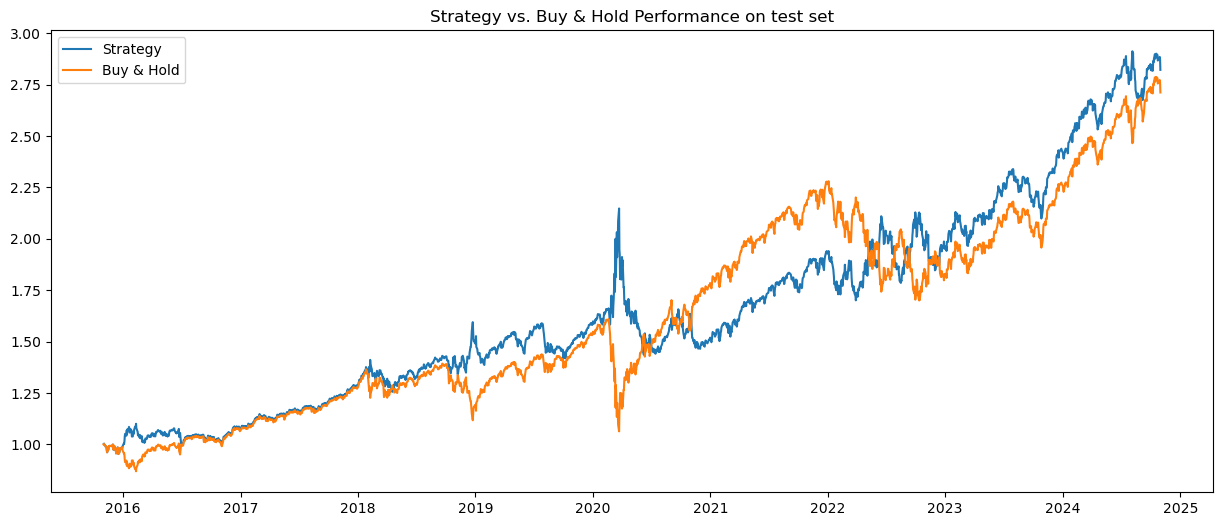

In [445]:
data['StrategyReturns'] = data['Signal'].shift(1) * data['Returns']
data['CumulativeReturns'] = (1 + data['StrategyReturns']).cumprod()
data['BuyAndHoldReturns'] = (1 + data['Returns']).cumprod()
plt.figure(figsize=(15, 6))
plt.plot(data['Date'], data['CumulativeReturns'], label='Strategy')
plt.plot(data['Date'], data['BuyAndHoldReturns'], label='Buy & Hold')
plt.legend()
plt.title("Strategy vs. Buy & Hold Performance on test set")
plt.show()

In [446]:
# Get Test data
ticker_yahoo = yf.Ticker(TICKER)
test_data = ticker_yahoo.history(interval=INTERVAL, start=START_TEST, end=END_TEST)
last_quote = test_data['Close'].iloc[-1]
test_data['Returns'] = test_data['Close'].pct_change().fillna(0)
test_data['LogReturns'] = np.log1p(test_data['Returns'])
test_data['Volatility'] = test_data['LogReturns'].rolling(window=20).std().fillna(0)
test_data = test_data.reset_index()
print(ticker, last_quote)
test_observables = test_data[['LogReturns']].values #, 'Volatility'
if scaling:
    scaler = StandardScaler()
    test_observables = scaler.fit_transform(test_observables)
if 'Datetime' in test_data.columns:
    test_data.rename(columns={'Datetime': 'Date'}, inplace=True)

USDJPY=X 6051.08984375


In [447]:
#Running model on test data
hidden_states_test = hmm.predict(test_observables)
test_data['HiddenState'] = hidden_states_test

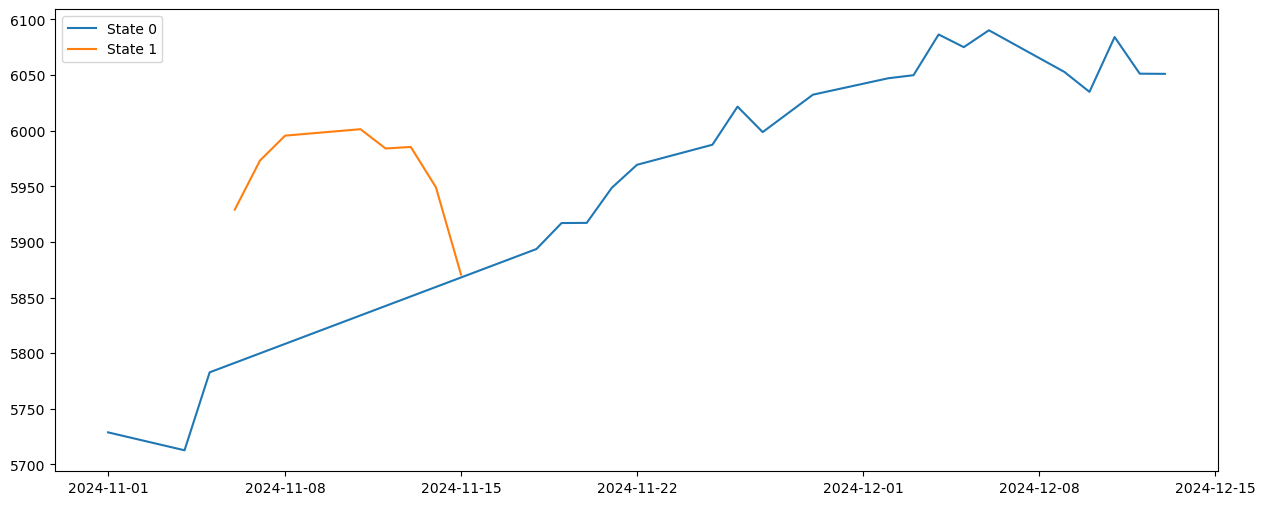

In [448]:
# Visualize the hidden states
plt.figure(figsize=(15, 6))
for state in range(hmm.n_components):
    state_data_test = test_data[test_data['HiddenState'] == state]
    plt.plot(state_data_test['Date'], state_data_test['Close'], label=f"State {state}")
plt.legend()
plt.show()

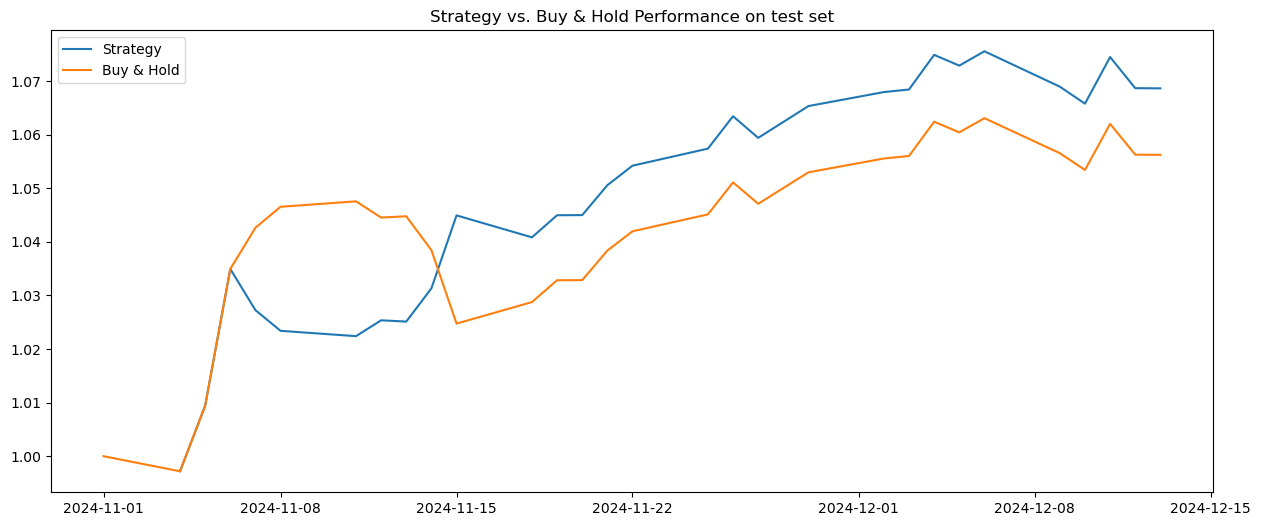

In [449]:
test_data['Signal'] = 0
test_data.loc[test_data['HiddenState'] == index_max, 'Signal'] = 1  # Buy
test_data.loc[test_data['HiddenState'] == index_min, 'Signal'] = -1 # Sell
test_data['StrategyReturns'] = test_data['Signal'].shift(1) * test_data['Returns']
test_data['CumulativeReturns'] = (1 + test_data['StrategyReturns']).cumprod()
test_data['BuyAndHoldReturns'] = (1 + test_data['Returns']).cumprod()
plt.figure(figsize=(15, 6))
plt.plot(test_data['Date'], test_data['CumulativeReturns'], label='Strategy')
plt.plot(test_data['Date'], test_data['BuyAndHoldReturns'], label='Buy & Hold')
plt.legend()
plt.title("Strategy vs. Buy & Hold Performance on test set")
plt.show()